# TP : k-plus proches voisins, analyse discriminante et régression logistique

J'ai changé des fonctions pour repondre à mes besoins dans ce tp. Les voici, ci-dessous:

In [1]:
def frontiere_new(f, X, y, w = None, step = 50, alpha_choice = 1, aspect = 'auto', colorbar = True,
                  samples = True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f([vec]) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin = 'lower', interpolation = "mitchell", alpha = 0.80,
               cmap = my_cmap, extent = [min_tot0, max_tot0, min_tot1, max_tot1], aspect = 'auto')
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks = labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c = color_blind_list[label_num],
                       s=80, marker = symlist[label_num])
            #plt.scatter(X[i, 0], X[i, 1], s=80)
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

        
###############################################################################
#               Algorithms and functions
###############################################################################


class ErrorCurve(object):
    def __init__(self, k_range = None, weights = 'uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, Xtest, ytest):
        def error_func(k):
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            knn.fit(X, y)
            error = np.mean(knn.predict(Xtest) != ytest)
            return error

        errors = list(map(error_func, self.k_range))
        self.errors = np.array(errors)
        self.y = y

    def plot(self, marker = 'o',color = 'b',label = None, maketitle = True, **kwargs):
        plt.plot(self.k_range, self.errors, marker = marker, color = color,label = label,**kwargs)
        plt.xlabel("K")
        plt.ylabel("Test error")
        if maketitle:
            plt.title("number of training points : %d" % len(self.y))


## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
from matplotlib import rc
import pandas as pd
import tp_knn_source
import scipy.spatial.distance
import statsmodels
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import neighbors, datasets
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from tp_knn_source import rand_bi_gauss,rand_tri_gauss,rand_checkers,rand_clown,rand_gauss,plot_2d, frontiere, frontiere_new, LOOCurve
from tp_knn_source import ErrorCurve
from sklearn.metrics import confusion_matrix
from sklearn import datasets, metrics
import statsmodels
from scipy.stats import mode
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
import warnings
warnings.filterwarnings('ignore')

/home/karine/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Génération artificielle des données

## Question 1 : Etude des différentes distributions

In [3]:
#Données #1 
#paramètres égaux à ceux du TP1
#Je mets n1 et n2 un peu plus grand que ce qui est demandé pour que l'on puisse mieux voir les classifications
#dans la visualisation à la question 5
X1, y1 = rand_bi_gauss(n1 = 30, n2 = 30, mu1 = [1, 1], mu2 = [-1, -1],
                      sigmas1 = [0.9, 0.9], sigmas2 = [0.9, 0.9])

#Données #2
X2, y2 = rand_tri_gauss(n1 = 50, n2 = 50, n3 = 50, mu1 = [1, 1], mu2 = [-1, -1], mu3 = [1, -1], 
                       sigma1 = [0.9, 0.9], sigma2 = [0.9, 0.9], sigma3 = [0.9, 0.9])

#Données #3 
#paramètres égaux à ceux du TP1
n1 = 50
n2 = 50
sigmas1 = 1. 
sigmas2 = 5.
X3, y3 = rand_clown(n1 , n2, sigmas1, sigmas2)

#Données #4
n1 = 150
n2 = 150
sigma = 0.9
X4, y4 = rand_checkers(n1, n2, sigma)

#### Description des fonctions

1. La fonction <font color=blue>rand_bi_gauss <font color=black>génére un mélange aléatoire de 2 distributions gaussienne de paramètre 
respectives (mu1, sigma1) et (mu2, sigma2), étant le couple (moyenne, variance) pour chaque distribution.
Le nombre de points généré pour chaque distribution est n1 pour la première distribution et n2 pour la 2eme distribution.
2. La fonction <font color=blue>rand_tri_gauss  <font color=black>génére un mélange aléatoire de 3 distributions gaussienne (similaire à la fonction bi_gauss).
3. La fonction <font color=blue>rand_clown<font color=black> génére un mélange aléatoire de 2 distribution: une distribution parabolique de variance sigma et une distribution de moyenne nulle.
4. La fonction <font color=blue>rand_checkers<font color=black> génére un damier aléatoire.

#### Que représente la dernière colonne (y) ?

Elle représente la classe (appelé aussi label) associée à chaque point x.

## Question 2 : Représentation graphique des distributions 

Text(0.5,1,'Fourth data set')

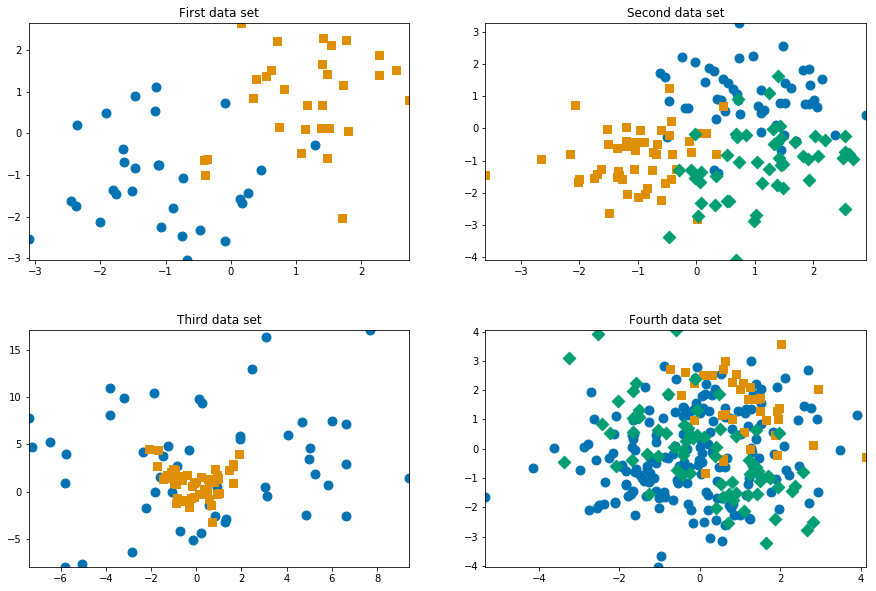

In [4]:
fig=plt.figure(1, figsize=(15, 10))

plt.subplot(221)
plot_2d(X1, y1)
plt.title('First data set')

plt.subplot(222)
plot_2d(X2, y2)
plt.title('Second data set')


fig.subplots_adjust(hspace=0.3)
plt.subplot(223)
plot_2d(X3, y3)
plt.title('Third data set')


plt.subplot(224)
plot_2d(X4, y4)
plt.title('Fourth data set')

#### Observations 

Nous pouvons observés pour les données 1 et 2 des données provenant d'un mélange de lois gaussienne.
On peut en déduire qu'elles sont séparables linéairement. Appliquer un LDA à ce jeu de donnée est pertinent.
En revanche pour les données 3 provenant d'un mélange de lois non gaussienne, on peut se rendre compte qu'elles
ne peuvent pas être classifiable par la méthode LDA. Cependant les classer par un classifieur k-nn est pertinent
vu la distribution des données

# k-plus proches voisins 

## Question 3 : k-plus proches voisins regression

Pour le cas de la régression, quand les observations y sont à valeurs réelles, on associe à chaque groupe de k-voisins la moyenne de ces points.


## Question 4 : Classe k-nn classification artisanale

In [5]:
from scipy.stats import mode
class KNNClassifier(BaseEstimator, ClassifierMixin):
#""" Homemade kNN classifier class """
    #Define the training set
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors
    # Complete the mehtod
    def fit(self, X, y):
        self.xtrain = X
        self.ytrain = y
        return self
    
    def predict(self, X_test):
        # Une ligne correspond à un point du tes set et chaque colonne
        # à un point du training set
        Md = cdist(X_test, self.xtrain, "euclidean")
        # Ordonner la liste des voisins training par points du test set
        neighbors_all = np.argsort(Md, axis =1)
        neigh = neighbors_all[:,:self.n_neighbors]
        Y = self.ytrain[neigh]
        majority, nb = mode(Y, axis = 1) 
        Y_pred = majority.squeeze()
        return Y_pred

In [6]:
test = KNNClassifier(3)
test.fit(X2[::2],y2[::2])
artisanal_label = test.predict(X2[1::2])
print(f"Les labels prédits pour la fonction test avec un modèle knn voisins ayant 3 voisins : ")
print(artisanal_label)

Les labels prédits pour la fonction test avec un modèle knn voisins ayant 3 voisins : 
[3. 1. 2. 3. 3. 2. 3. 1. 3. 2. 2. 2. 1. 1. 3. 3. 3. 1. 2. 1. 2. 2. 2. 1.
 1. 2. 1. 2. 3. 1. 2. 3. 3. 3. 3. 2. 1. 1. 2. 1. 1. 3. 2. 2. 1. 2. 3. 3.
 3. 1. 3. 3. 1. 2. 1. 1. 3. 1. 1. 1. 3. 2. 1. 3. 1. 1. 2. 3. 1. 3. 3. 1.
 3. 1. 2.]


### Comparaison avec sklearn

#### Résultats avec sklearn

In [7]:
from sklearn import neighbors, datasets
clf = neighbors.KNeighborsClassifier(3)
clf.fit(X2[::2],y2[::2])
label_predict_sklearn = clf.predict(X2[1::2])
print(f"Les labels prédits pour la fonction test avec un modèle knn voisins ayant 3 voisins : ")
print(label_predict_sklearn)

Les labels prédits pour la fonction test avec un modèle knn voisins ayant 3 voisins : 
[3. 1. 2. 3. 3. 2. 3. 1. 3. 2. 2. 2. 1. 1. 3. 3. 3. 1. 2. 1. 2. 2. 2. 1.
 1. 2. 1. 2. 3. 1. 2. 3. 3. 3. 3. 2. 1. 1. 2. 1. 1. 3. 2. 2. 1. 2. 3. 3.
 3. 1. 3. 3. 1. 2. 1. 1. 3. 1. 1. 1. 3. 2. 1. 3. 1. 1. 2. 3. 1. 3. 3. 1.
 3. 1. 2.]


#### Comparaison entre la library sklearn et la library artisanale

##### Comparaison labels prédits des 2 librairies

In [8]:
label_predict_sklearn == artisanal_label 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

##### Frontière de prédiction pour comparer les 2 librairies : sklearn et fait-maison

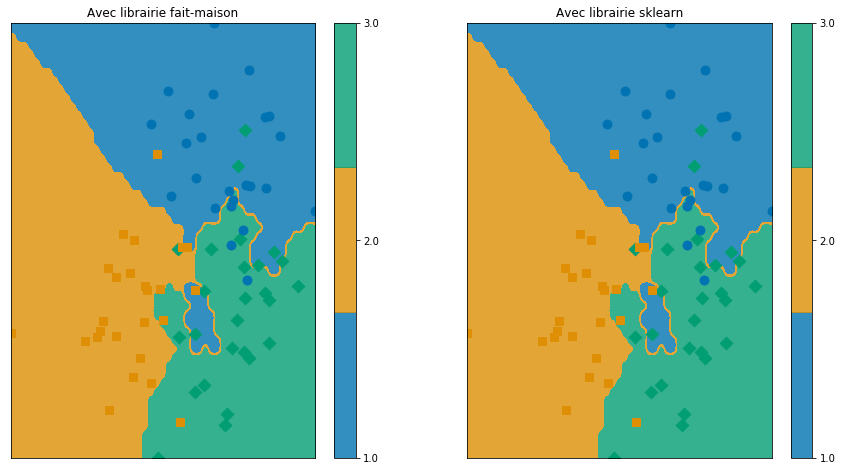

In [9]:
plt.figure(figsize=(15,8))

plt.subplot(121)
plt.title("Avec librairie fait-maison")
def f_artis(x):
    return test.predict(x)

frontiere_new(f_artis, X2[1::2], y2[1::2])
plt.subplot(122)
plt.title("Avec librairie sklearn")
def f_sklearn(x):
    return clf.predict(x)
frontiere_new(f_sklearn,X2[1::2],y2[1::2])

 La librarie artisanale de knn voisins donne les mêmes résultats que la librairie sklearn.

## Question 5 : Visualisation de la frontière du k-nn classifieur sur les jeux de données

In [10]:
n_voisins = 5
clf = neighbors.KNeighborsClassifier(n_voisins)

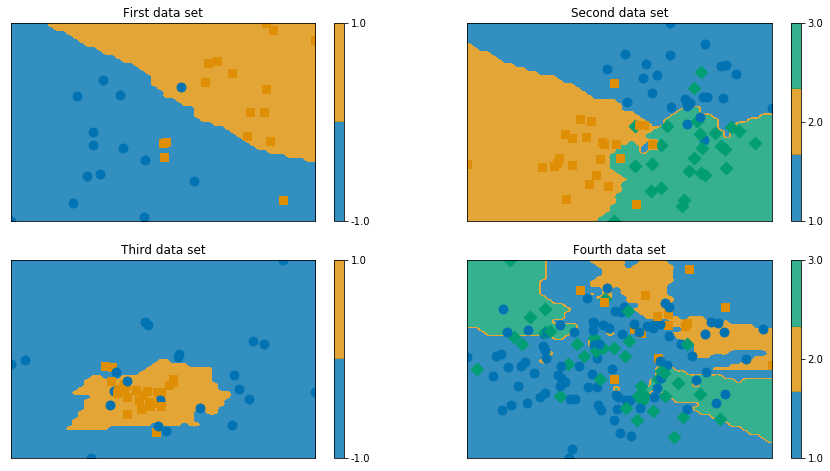

In [11]:
plt.figure(figsize=(15, 8))

plt.subplot(221)

clf.fit(X1[::2],y1[::2])
def f(x):
        return clf.predict(x)
clf.predict(X1[1::2])

plt.title('First data set')
frontiere_new(f, X1[1::2], y1[1::2])
#frontiere()
plt.subplot(222)

clf.fit(X2[::2],y2[::2])
def f(x):
        return clf.predict(x)


plt.title('Second data set')
frontiere_new(f, X2[1::2], y2[1::2])
plt.subplot(223)
plt.title('Third data set')

clf.fit(X3[::2],y3[::2])
def f(x):
        return clf.predict(x)
clf.predict(X3[1::2])
frontiere_new(f,X3[1::2], y3[1::2])

clf.fit(X4[::2],y4[::2])
def f(x):
        return clf.predict(x)
clf.predict(X4[1::2])
plt.subplot(224)
plt.title('Fourth data set')
frontiere_new(f, X4[1::2], y4[1::2])

#### Observation 

Nos jeux de données sont relativement bien classées avec quelques erreurs. Plus nos données sont générées par des distributions complexes (non gaussienne), moins la classification est bonne.

## Question 6 : Influence du nombre de voisins sur les frontières de décision

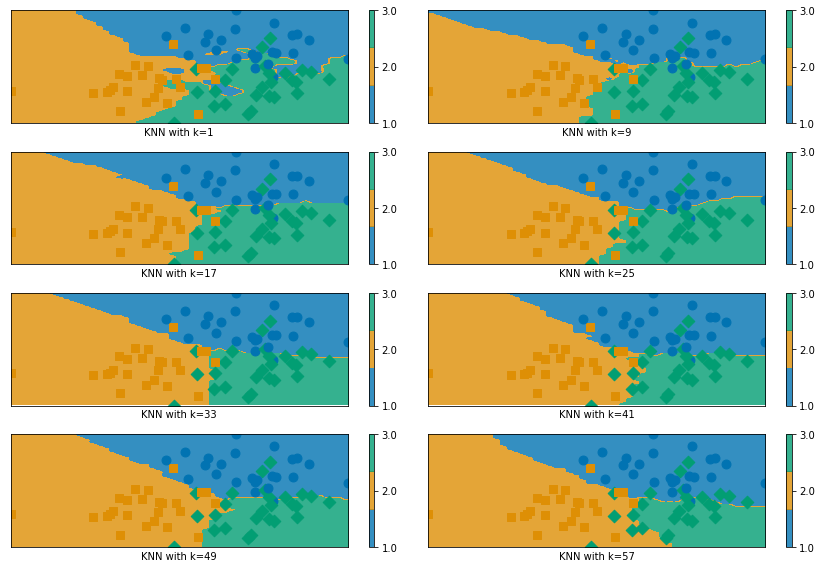

In [12]:
plt.figure(3, figsize=(12, 8))
iterate=0
for n_neighbors in range(1, 60, 8):
    iterate=iterate+1
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X2[::2],y2[::2])
    plt.subplot(4, 2, iterate)
    plt.xlabel('KNN with k=%d' % n_neighbors)
    def f(x):
        return knn.predict(x)
    frontiere_new(f, X2[1::2], y2[1::2])


plt.tight_layout()
plt.show()

#### Observation :

Les frontières se simplifient avec k qui grandit.

Faisons un zoom sur pour 2 valeurs de k extrèmes.

#### 2 Valeurs de k extrèmes

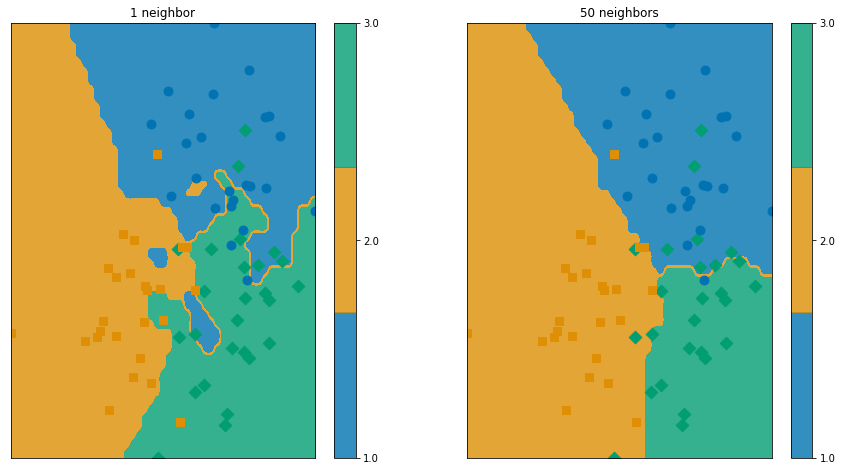

In [13]:
plt.figure(3, figsize=(15, 8))
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X2[::2],y2[::2])
def f(x):
        return knn.predict(x)
plt.subplot(121)
plt.title('1 neighbor')
frontiere_new(f, X2[1::2], y2[1::2])

knn = neighbors.KNeighborsClassifier(n_neighbors=50)
knn.fit(X2[::2],y2[::2])
def f(x):
        return knn.predict(x)
plt.subplot(122)
plt.title('50 neighbors')
frontiere_new(f, X2[1::2], y2[1::2])

#### Observations :

On remarque que plus le nombre de voisins, et plus les frontières entre les classes sont lissées.
En effet, en augmentant le nombre de voisins, on lisse les différences et les frontières deviennent simples.

1. Quand k = 1, la frontière est très complexe.
2. Quand k = n, la frontière est simple.

## Question 7 : Pondérer les poids du jème voisin 

Le poids attribuée au j-eme voisin est $$ w_{j}=\exp{(-\frac{d_{j}^{2}}{h})} $$

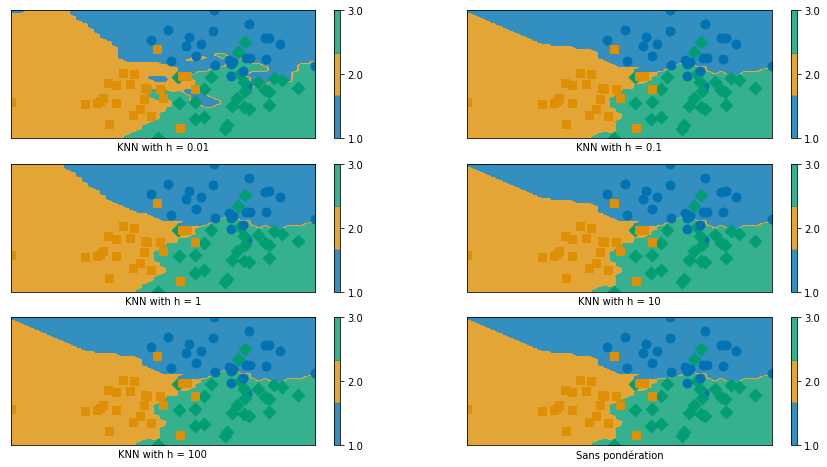

In [14]:
fig = plt.figure(figsize=(15, 8))

def weights(dist):
            h_ = 0.01
            w = np.exp(-dist**2/h_)
            return w
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, weights = weights )
knn.fit(X2[::2],y2[::2]) 
def f(x):
    return knn.predict(x)
plt.subplot(3,2,1)  
plt.xlabel('KNN with h = 0.01')
frontiere_new(f,X2[1::2],y2[1::2])

def weights(dist):
            h_ = 0.1
            w = np.exp(-dist**2/100)
            return w
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, weights = weights )
knn.fit(X2[::2],y2[::2]) 
def f(x):
    return knn.predict(x)
plt.subplot(3,2,2)  
plt.xlabel('KNN with h = 0.1')
frontiere_new(f,X2[1::2],y2[1::2])

def weights(dist):
            h_ = 1
            w = np.exp(-dist**2)
            return w
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, weights = weights )
knn.fit(X2[::2],y2[::2]) 
def f(x):
    return knn.predict(x)
plt.subplot(3,2,3)  
plt.xlabel('KNN with h = 1')
frontiere_new(f,X2[1::2],y2[1::2])

def weights(dist):
            h_ = 10
            w = np.exp(-dist**2/h_)
            return w
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, weights = weights )
knn.fit(X2[::2],y2[::2]) 
def f(x):
    return knn.predict(x)
plt.subplot(3,2,4)  
plt.xlabel('KNN with h = 10')
frontiere_new(f,X2[1::2],y2[1::2])


def weights(dist):
            h_ = 100
            w = np.exp(-dist**2/h_)
            return w
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, weights = weights )
knn.fit(X2[::2],y2[::2]) 
def f(x):
    return knn.predict(x)
plt.subplot(3,2,5)  
plt.xlabel('KNN with h = 100')
frontiere_new(f,X2[1::2],y2[1::2])



knn = neighbors.KNeighborsClassifier(n_neighbors = 7, weights = None )
knn.fit(X2[::2],y2[::2]) 
def f(x):
    return knn.predict(x)
plt.subplot(3,2,6)  
plt.xlabel('Sans pondération')
frontiere_new(f,X2[1::2],y2[1::2])

#### Observation

Il est difficile de juger de l'amélioration des résultats avec la pondération. 
On remarque une légère différence dans le lissage de la frontière avec h plus grand.

## Question 8: Taux d'erreur

### Taux d'erreur sur les données d'apprentissage

In [15]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 1)
knn.fit(X2[::2],y2[::2])
erreur=1-knn.score(X2[::2],y2[::2])
print("Le taux d'erreur sur les données test est : " + str(round(erreur,3)))

Le taux d'erreur sur les données test est : 0.0


### Taux d'erreur sur les données de test

In [16]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 1)
knn.fit(X2[::2],y2[::2])
erreur=1-knn.score(X2[1::2],y2[1::2])
print("Le taux d'erreur sur les données test est : " + str(round(erreur,3)))


Le taux d'erreur sur les données test est : 0.227


#### Observation : "Overfitting"

On remarque ainsi que notre modèle "overfit", surraprend les données d'entrainement. Il faut donc enlever un peu de complexité au modèle pour éviter cet "overfitting".

## Question 9 : Tracer le taux d'erreur en fonction de k

No handles with labels found to put in legend.


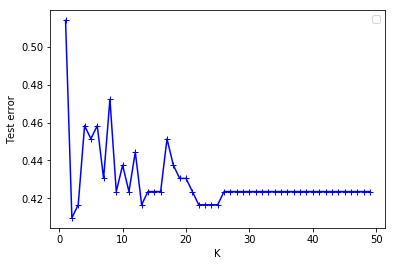

In [17]:
#Données #4
n1 = 150
n2 = 150
sigma = 0.9
X4, y4 = rand_checkers(n1, n2, sigma)
X4_error = ErrorCurve(k_range=list(range(1,50)))
X4_error.fit_curve(X4[::2],y4[::2], X4[1::2],y4[1::2])
X4_error.plot(maketitle=False,marker='+',color='blue')
plt.legend()

Pour ce jeu de données, le meilleur k (celui qui donne l'erreur la plus faible) est 30. On évite de prendre un trop grand k par peur de overfitting.

## Question 10 : Tracer le taux d'erreur en fonction des échantillons et du k

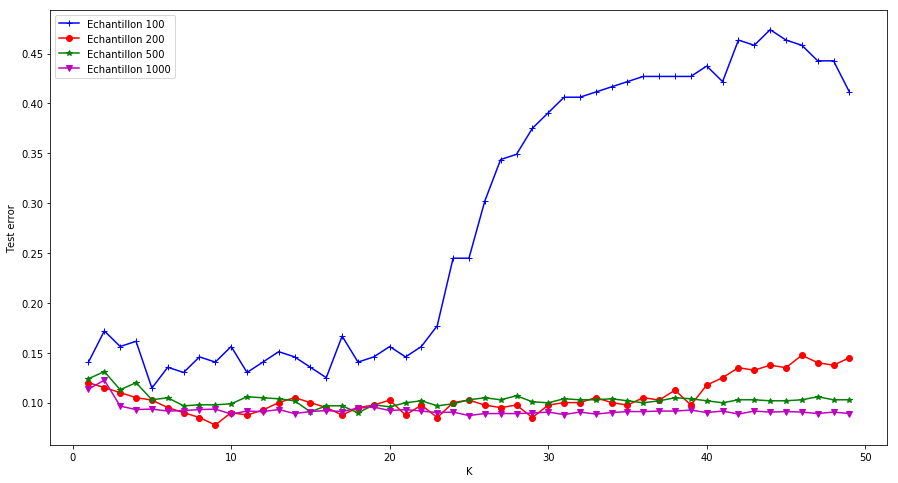

In [18]:
samples=[100,200,500,1000]
m=['+','o','*','v','h']
c=['b','r','g','m','c']
sigma = 0.1
plt.figure(4, figsize=(15, 8))
for iteration, sample in enumerate(samples):
    label='Echantillon ' +str(sample)
    n1 = sample
    n2 = sample
    X_train, Y_train = rand_checkers(n1, n2, sigma)
    X_test, Y_test = rand_checkers(n1, n2, sigma)
    X4_error = ErrorCurve(k_range=list(range(1,50)))
    X4_error.fit_curve(X_train,Y_train, X_test,Y_test)
    marker_ = m[iteration]
    color_ = c[iteration]
    
    X4_error.plot(maketitle=False,marker=marker_,color=color_,label=label)
    plt.legend()

##### Influence de la taille de l'échantillon sur le taux d'erreur 

1. On observe que plus l'échantillon est grand et moins l'erreur est grande.
2. De plus on remarque que le meilleur k n'est pas le même pour les différentes taille d'échantillon. 
   Ce qui est logique.

##### Meilleure k (celui qui donne un taux d'erreur le plus faible)

1. Pour l'échantillon de taille 100, le meilleur k est 1
2. Pour l'échantillon de taille 200, le meilleur k est 13
3. Pour l'échantillon de taille 500, le meilleur k est 20
4. Pour l'échantillon de taille 1000, le meilleur k est 20

#### Visualisation des donnéers et la régle de décision pour échantillon = 1000

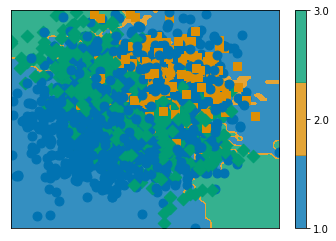

In [19]:
n1 = n2 = 1000
sigma = 0.9
X_train, Y_train = rand_checkers(n1, n2, sigma)
X_test, Y_test = rand_checkers(n1, n2, sigma)
knn = neighbors.KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, Y_train)
def f(x):
        return knn.predict(x)
frontiere_new(f, X_test, Y_test)

## Question 11 : Avantages et inconvénients de la méthode des plus proches voisins 

#### Avantage 

La méthode des plus proches voisins est interprétable car le concept est simple.

#### Inconvénients

Le temps de calcul est plus important que d'autres classifieurs car il faut à chaque fois, mesurer
la distance entre tous les points. Elle est donc très gourmande en temps et mémoire. Il est donc très coûteux de l'utiliser pour des problèmes à grande dimension. On peut donc avoir des problèmes importants de passage à l'échelle.

##  Question 12 : Base Digits de scikit-lean

### Nature et format des données

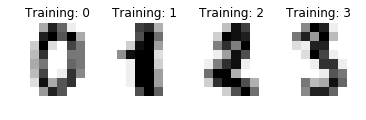

In [20]:
# The digits dataset
digits = datasets.load_digits()
# The digits dataset
digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)


Les données sont des images de chiffres pixellisées.

### Histogramme pour des classes

Text(0,0.5,'Density')

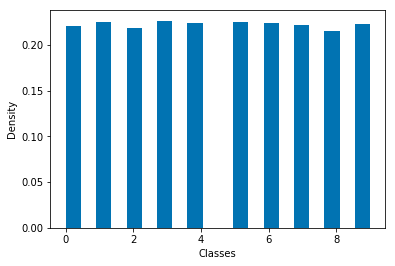

In [21]:
label1=[]
image1=[]
for index, (image, label) in enumerate(images_and_labels):
    label1.append(label)
    
plt.hist(label1 , bins = 20, density = True)
plt.xlabel("Classes")
plt.ylabel("Density")


##### Observations

Les classes sont réparties de façon équitable

### Knn classification appliquée à la base des digits

In [22]:
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier

classifier=neighbors.KNeighborsClassifier(n_neighbors=30)
# We learn the digits on the first half of the digits

classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])
# Now predict the value of the digit on the second half:

expected= digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])

print("---------------------------------------------------------------------------")
print(f"        Le taux d'erreur est {round(1-metrics.r2_score(expected, predicted),3)}")
print("---------------------------------------------------------------------------")
print("---------------------------------------------------------------------------")

print("---------------------------------------------------------------------------")
print("Les différentes métrique du classifieur %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("---------------------------------------------------------------------------")


---------------------------------------------------------------------------
        Le taux d'erreur est 0.172
---------------------------------------------------------------------------
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Les différentes métrique du classifieur KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform'):
             precision    recall  f1-score   support

          0       0.96      0.99      0.97        88
          1       0.93      0.90      0.92        91
          2       0.92      0.92      0.92        86
          3       0.83      0.89      0.86        91
          4       0.99      0.95      0.97        92
          5       0.89      0.93      0.91        91
          6       0.96      1.00      0.98        91
          7       0.93      0.

## Question 13: Matrice de confusion associée au classifieur

In [23]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 82  5  1  0  1  0  0  0  2]
 [ 1  0 79  6  0  0  0  0  0  0]
 [ 0  0  0 81  0  3  0  4  1  2]
 [ 2  0  0  0 87  0  0  2  1  0]
 [ 0  0  0  0  0 85  3  0  0  3]
 [ 0  0  0  0  0  0 91  0  0  0]
 [ 0  0  1  0  0  0  0 88  0  0]
 [ 0  6  1  6  0  4  1  1 68  1]
 [ 1  0  0  4  0  2  0  0  1 84]]


## Question 14: Choix de k grâce à la validation croisée

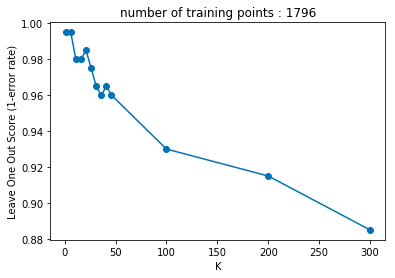

In [24]:
rangek = [1,6,11,16,21,26,31,36,41,46,100,200,300]

CV_digits = LOOCurve(k_range = rangek)
CV_digits.fit_curve(data, digits.target)
CV_digits.plot()

#### Commentaire: 

Le meilleur moyen de trouver les hyperparamètres optimaux est la validation croisée. Ici est représenté le score
moyen testé sur tous les folds pour chaque k. 
On remarque que le meilleur k est égale à 1 car le score moyen est le plus élevé pour k = 1.

# Classe LDA

## Question 15 : Formule des probabilité a posteriori 

### Demonstration

#### 1. Formule de Bayes nous dit que: 

$$ Pr{ ( Y = 1 | X = x ) } =\frac{P{ (X | Y = 1 ) } Pr { (Y = 1 )}}{P{ (X)}} $$ et
$$ Pr{ ( Y = -1 | X = x ) } =\frac{P{ (X | Y = -1 ) } Pr { (Y = -1 )}}{P{ (X)}} $$ 


#### 2. Formule des probabilités totales nous dit que :


$$ P{ (X)} = P{ (X | Y = 1 ) } Pr { (Y = 1 )} + P{ (X | Y = -1 ) } Pr { (Y = -1 )} $$

d'où  le résultat:

$$ Pr{ ( Y = 1 | X = x ) } = \frac { pi_{+}f_{+} }{ pi_{+}f_{+} + pi_{-}f_{-}} $$ 




## Résultat

-----------------------------------------------------------------------------------------------------------------
$$ Pr{ ( Y = -1 | X = x ) } =\frac { pi_{-}f_{-} }{ pi_{+}f_{+} + pi_{-}f_{-}} $$
-----------------------------------------------------------------------------------------------------------------

## Question 16 : Log-ration des 2 classes

Pour implémenter la classification LDA, il nous faut faire l'hypothèse que les distributions des différentes classes sont gaussiennes. Ainsi dans notre cas où nous avons 2 classes, les densités sont égales à :

$$  f_{+} = \frac{1}{ (2 \pi) ^ {\frac{p}{2}} \sqrt{\det(\Sigma)} } 
\exp {   (-\frac{1}{2} ({(x- \mu_{+})^T}
 \Sigma^{-1} ((x- \mu_{+})) 
}  
$$

et

$$  f_{-} = \frac{1}{ (2 \pi) ^ {\frac{p}{2}} \sqrt{\det(\Sigma)} } 
\exp {   (-\frac{1}{2} ({(x- \mu_{-})^T}
 \Sigma^{-1} ((x- \mu_{-})) 
}  
$$

d'où la probabilité a postériori s'écrit : 

$$ Pr{ ( Y = 1 | X = x ) } = \frac { \frac{m}{n}  f_{+} }{\frac{m}{n} f_{+} + (1-\frac{m}{n}) f_{-}}  $$


et


$$ \frac{Pr{ ( Y = 1 | X = x ) }}{Pr{ ( Y =- 1 | X = x ) }}  =   \frac { \frac{m}{n}  f_{+} }{ (1-\frac{m}{n})  f_{-} }$$


En prenant le log on obtient :

$$ \log(\frac{Pr{ ( Y = 1 | X = x ) }}{Pr{ ( Y =- 1 | X = x ) }}) =  \log ( \frac{m}{n}  f_{+}    ) - 
\log ( (1-\frac{m}{n}) f_{-}  ))
=  \log ( \frac{m}{n}) + \log (f_{+}  ) - \log (f_{-} ) - \log ( (1-\frac{m}{n})
$$ 


$$\log {f_{+} } =  (-\frac{1}{2} ({(x- \mu_{+})^T}
 \Sigma^{-1} ((x- \mu_{+})  (-( \log(2 \pi ) ( (\frac{p}{2}))  +  \frac{1}{2}  \log {\det {\Sigma} } ) $$
 

$$\log {f_{-} } =  (-\frac{1}{2} ({(x- \mu_{-})^T}
 \Sigma^{-1}((x- \mu_{-})  (-( \log(2 \pi ) (\frac{p}{2}))  + \frac{1}{2}  \log {\det {\Sigma} } ) $$ 
 
 $$ \log(\frac{Pr{ ( Y = 1 | X = x ) }}{Pr{ ( Y =- 1 | X = x ) }}) = \log(m/n)+\log(f_{+}) -\log(1-\frac{m}{n})-\log(f_{-})$$
 


---------------------------------------------------------------------
$$ \log(\frac{Pr{ ( Y = 1 | X = x ) }}{Pr{ ( Y =- 1 | X = x ) }}) = x^{T} \Sigma^{-1}(\mu_{+}-\mu_{-}) -\frac{1}{2} \mu^{T}_{+}\Sigma^{-1}\mu_{+}    
+ \frac{1}{2} \mu^{T}_{-}\Sigma^{-1}\mu_{-} - \log(1-\frac{m}{n}) + \log(\frac{m}{n})$$
---------------------------------------------------

## Question 17 : Choix du classifieur

Si la classe est égale à 1 alors cela signifie que la probabilité a posteriori de la classe égale à 1
est supèrieure à l'autre classe d'où
$$\log(\frac{Pr{ ( Y = 1 | X = x ) }}{Pr{ ( Y =- 1 | X = x ) }}) > 1$$
alors d'après Question 16
$$ x^{T} \Sigma^{-1}(\mu_{+}-\mu_{-}) -\frac{1}{2} \mu^{T}_{+}\Sigma^{-1}\mu_{+}    
+ \frac{1}{2} \mu^{T}_{-}\Sigma^{-1}\mu_{-} - \log(1-\frac{m}{n}) + \log(\frac{m}{n}) > 0$$
d'où
$$ x^{T} \Sigma^{-1}(\mu_{+}-\mu_{-}) >\frac{1}{2} \mu^{T}_{+}\Sigma^{-1}\mu_{+}    
- \frac{1}{2} \mu^{T}_{-}\Sigma^{-1}\mu_{-} + \log(1-\frac{m}{n}) - \log(\frac{m}{n})  $$
et même raisonnement pour la classe égale à -1.

## Question 18 : Implémentation artisanale du classifieur LDA

In [25]:
class LDAClassifier(BaseEstimator, ClassifierMixin):
#""" Homemade kNN classifier class """
    #Define the training set
    #def __init__(self):
        #assert (k <= len(x)), "k cannot be greater than training_set length"
    # Complete the mehtod
    def fit(self, X, y):       
        Xp = X[y == 1, :]
        Xn = X[y == -1, :]
        Xp_x = Xp[:,0]
        Xp_y = Xp[:,1]
        n = len(X)
        m = len(Xp)
        meanp_x = np.mean(Xp_x)
        meanp_y = np.mean(Xp_y)
        meanp = np.array([meanp_x,meanp_y])
        Cov_p = np.cov(np.transpose(Xp))
        Xn_x = Xn[:,0]
        Xn_y = Xn[:,1]

        meann_x = np.mean(Xn_x)
        meann_y = np.mean(Xn_y)
        meann = np.array([meann_x,meann_y])
        Cov_n = np.cov(np.transpose(Xn))
        
        Cov_tot = (1/(n-2))*( (m-1)* Cov_p + (n-m-1)* Cov_n)
        inv_Cov_tot = np.linalg.inv(Cov_tot)
        
        a1 = np.dot(np.transpose(meanp),inv_Cov_tot)
        a2 = np.dot(np.transpose(meann),inv_Cov_tot)
        
        self.alpha = 0.5*(np.dot(a1,meanp)  - np.dot(a2,meann)) + np.log(1- m/n) - np.log(m/n)
        self.beta =  np.dot(inv_Cov_tot,meanp-meann)
        return self
    
    def predict(self, X):
        y_=[]
        for i in range(len(X)):
            Xpred = X[i]
            b = np.dot(np.transpose(Xpred), self.beta)
            if (b>self.alpha):
                Ypred = 1
            else:
                Ypred = -1
            y_.append(Ypred)
        return np.array(y_)

## Question 19 : Comparaison avec Sklearn library

### Cas où les échantillons ont une classe plus nombreuse qu'une autre.

###### Cas où les données d'entrainement sont plus petites que les données test (ce qui est demandé dans l'énoncé et
###### que je trouve bizarre car en principe on devrait faire en sorte d'avoir plus de données pour entrainer le modèle
###### que pour le tester...)

Le taux d'erreur sur les données test avec la librairie artisanale est : 0.029
Le taux d'erreur sur les données test avec la librairie sklearn est : 0.029


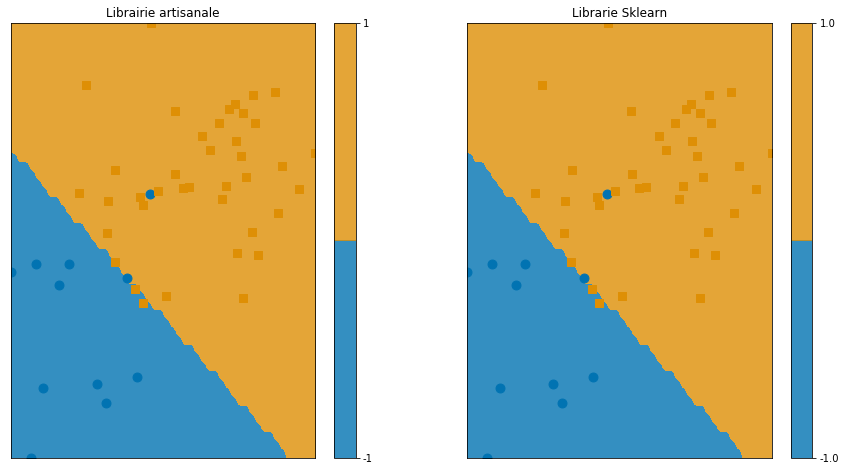

In [38]:
plt.figure(figsize=(15,8))
X1,y1=rand_bi_gauss(n1=100, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])
#X2,y2=rand_bi_gauss(n1=100, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[1, 1], sigmas2=[1, 1])
test= LDAClassifier()
test.fit(X1[:50],y1[:50])
test.predict(X1[50:])
def f1(x):
    return test.predict(x)
plt.subplot(121)
plt.title("Librairie artisanale")
frontiere_new(f1,X1[:50],y1[:50])
erreur = 1-test.score(X1[50:],y1[50:])
print("Le taux d'erreur sur les données test avec la librairie artisanale est : " + str(round(erreur,3)))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
testsklearn=LinearDiscriminantAnalysis()
testsklearn.fit(X1[:50],y1[:50])
testsklearn.predict(X1[50:])
def f2(x):
    return testsklearn.predict(x)
plt.subplot(122)
plt.title("Librarie Sklearn")
frontiere_new(f2,X1[:50],y1[:50])
erreur = 1-testsklearn.score(X1[50:],y1[50:])
print("Le taux d'erreur sur les données test avec la librairie sklearn est : " + str(round(erreur,3)))

##### Cas où les données d'entrainement sont plus grandes que les données test (ce que je trouve plus pertinent)

Le taux d'erreur sur les données test avec la librairie artisanale est : 0.04
Le taux d'erreur sur les données test avec la librairie sklearn est : 0.04


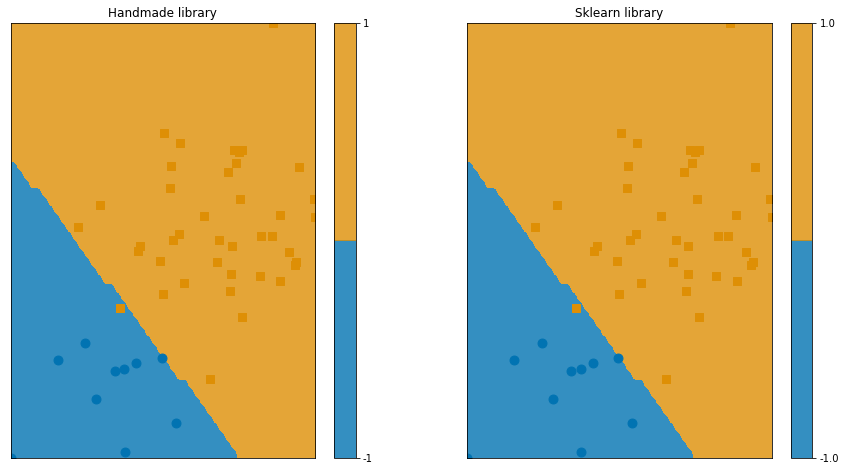

In [27]:
plt.figure(figsize=(15,8))
X1,y1=rand_bi_gauss(n1=200, n2=40, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])

test= LDAClassifier()
test.fit(X1[50:],y1[50:])
test.predict(X1[:50])
def f1(x):
    return test.predict(x)
plt.subplot(121)
plt.title("Handmade library")
frontiere_new(f1,X1[:50],y1[:50])
erreur = 1-test.score(X1[:50],y1[:50])

print("Le taux d'erreur sur les données test avec la librairie artisanale est : " + str(round(erreur,3)))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
testsklearn=LinearDiscriminantAnalysis()
testsklearn.fit(X1[50:],y1[50:])
testsklearn.predict(X1[:50])
def f2(x):
    return testsklearn.predict(x)
plt.subplot(122)
plt.title("Sklearn library")
frontiere_new(f2,X1[:50],y1[:50])
erreur = 1-testsklearn.score(X1[:50],y1[:50])
print("Le taux d'erreur sur les données test avec la librairie sklearn est : " + str(round(erreur,3)))

#### Cas où le nombre de classe est le même

Le taux d'erreur sur les données test avec la librairie artisanale est : 0.0
Le taux d'erreur sur les données test avec la librairie sklearn est : 0.0


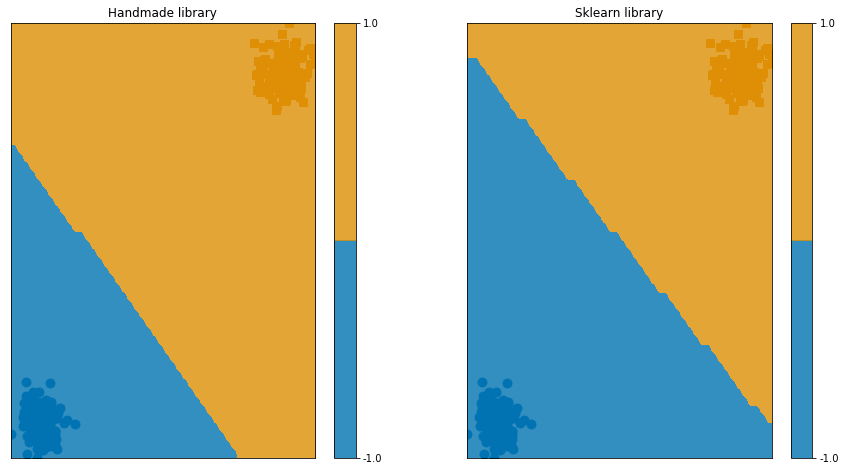

In [28]:
import sklearn.metrics
from sklearn.metrics import f1_score
plt.figure(figsize=(15,8))
X1,y1=rand_bi_gauss(n1=200, n2=200, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1], sigmas2=[0.1, 0.1])
#X2,y2=rand_bi_gauss(n1=1000, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1], sigmas2=[0.1, 0.1])
test= LDAClassifier()
test.fit(X1[:150],y1[:150])
test.predict(X1[150:])
def f1(x):
    return test.predict(x)
plt.subplot(121)
plt.title("Handmade library")
frontiere_new(f2,X1[150:],y1[150:])
erreur = 1-test.score(X1[150:],y1[150:])

print("Le taux d'erreur sur les données test avec la librairie artisanale est : " + str(round(erreur,3)))
testsklearn=LinearDiscriminantAnalysis()
testsklearn.fit(X1,y1)
testsklearn.predict(X2)

erreur = 1-testsklearn.score(X1[150:],y1[150:])
print("Le taux d'erreur sur les données test avec la librairie sklearn est : " + str(round(erreur,3)))
def f2(x):
    return testsklearn.predict(x)
plt.subplot(122)
plt.title("Sklearn library")
frontiere_new(f2,X1[150:],y1[150:])

## Question 20 : Validité de la classe LDA Classifier sur les jeux de données 1 et 3

### Jeux de données 1 : Classification LDA de données provenant d'un mélange de distribution gaussienne


Le taux d'erreur sur les données test avec la librairie artisanale est : 0.033
Le taux d'erreur sur les données test avec la librairie sklearn est : 0.033


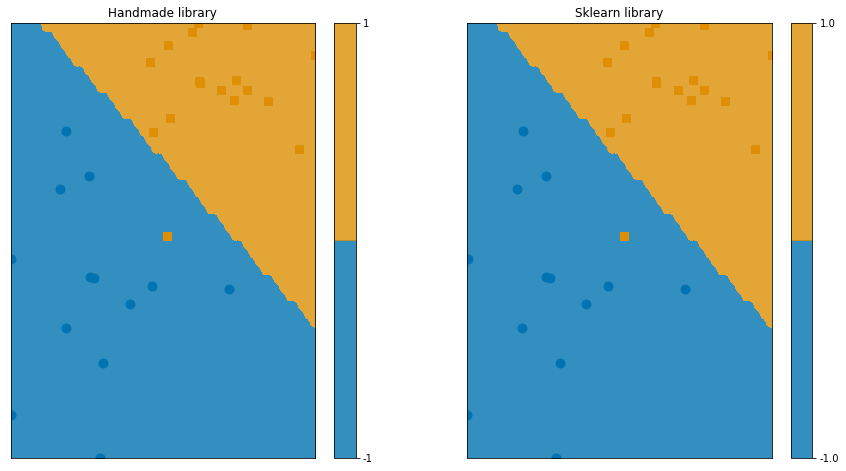

In [29]:
X1, y1 = rand_bi_gauss(n1 = 30, n2 = 30, mu1 = [1, 1], mu2 = [-1, -1],
                      sigmas1 = [0.9, 0.9], sigmas2 = [0.9, 0.9])

test = LDAClassifier()
test.fit(X1[::2],y1[::2])
plt.figure(figsize=(15,8))
def f1(x):
    return test.predict(x)
plt.subplot(121)
plt.title('Handmade library')
frontiere_new(f1,X1[1::2],y1[1::2])
erreur=1-test.score(X1[1::2],y1[1::2])# round(1-metrics.accuracy_score(expected, predicted),3)
print("Le taux d'erreur sur les données test avec la librairie artisanale est : " + str(round(erreur,3)))


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
testsklearn=LinearDiscriminantAnalysis()
testsklearn.fit(X1[::2],y1[::2])

def f2(x):
    return testsklearn.predict(x)
plt.subplot(122)
plt.title('Sklearn library')
frontiere_new(f2,X1[1::2],y1[1::2])

erreur=1-testsklearn.score(X1[1::2],y1[1::2])# round(1-metrics.accuracy_score(expected, predicted),3)
print("Le taux d'erreur sur les données test avec la librairie sklearn est : " + str(round(erreur,3)))

### Jeux de données 3 : Classification LDA de données provenant d'un mélange de distribution non gaussienne

In [30]:
n1 = 150
n2 = 150
sigmas1 = 0.1
sigmas2 = 0.1
X3, y3 = rand_clown(n1, n2, sigmas1, sigmas2)

Le taux d'erreur sur les données test est : 0.107
Le taux d'erreur sur les données test est : 0.107


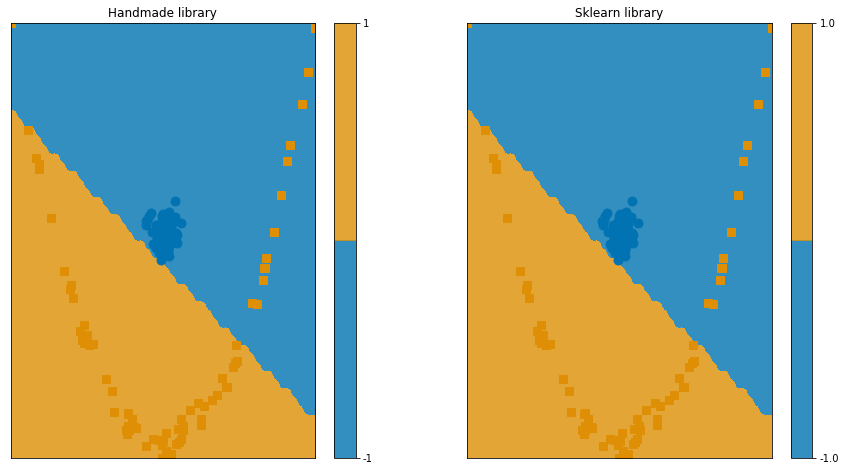

In [31]:
n1 = 150
n2 = 150
sigmas1 = 0.1
sigmas2 = 0.1
X3, y3 = rand_clown(n1, n2, sigmas1, sigmas2)
X4, y4 = rand_clown(n1, n2, sigmas1, sigmas2)
plt.figure(figsize=(15,8))


test= LDAClassifier()
test.fit(X3[::2],y3[::2])
def f1(x):
    return test.predict(x)
plt.subplot(121)
plt.title('Handmade library')
frontiere_new(f1,X3[1::2],y3[1::2])
erreur=1-test.score(X3[1::2],y3[1::2])
print("Le taux d'erreur sur les données test est : " + str(round(erreur,3)))


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
testsklearn=LinearDiscriminantAnalysis()
testsklearn.fit(X3[::2],y3[::2])

def f2(x):
    return testsklearn.predict(x)
plt.subplot(122)
plt.title('Sklearn library')
frontiere_new(f2,X3[1::2],y3[1::2])
erreur=1-testsklearn.score(X3[1::2],y3[1::2])
print("Le taux d'erreur sur les données test est : " + str(round(erreur,3)))

#### Observation : 


1. Cas du jeu de données 1 où les données sont bien classifiées.
Ce jeu de données suit un mélange de distributions gaussiennes, ainsi 
le classifieur LDA est bien adapté à ce cas. En effet il permet de bien séparer ce jeu de donnée car les hypothèses de gaussianité sur lesquels reposent ce clasiffieur sont bien établies.
2. Dans le cas du jeu de données 3 on obtient une mauvaise classification.
En effet les données ne suivent aucunement des distributions gaussiennes, ainsi on ne peut pas apliquer la LDA.
Cependant dans ce cas de jeux de données, le classifieur knn_voisins est approprié.

# Régression logistique

Pour le cas où les données sont linéairement séparables, la régression logistique devrait bien fonctionner sans nécessité d'avoir une hypothèse de distribution gaussienne sur les données.

## Question 21 : Classification par régression logistique

#### Cas où les classes sont déséquilibrées

In [32]:
X1,y1=rand_bi_gauss(n1=500, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])
lr=LogisticRegression()
lr.fit(X1[::2],y1[::2])
lr.predict(X1[1::2])

lda=LinearDiscriminantAnalysis()
lda.fit(X1[::2],y1[::2])
lda.predict(X1[1::2])



#Taux d'erreur

errlda=1-lda.score(X1[1::2],y1[1::2])
errlr=1-lr.score(X1[1::2],y1[1::2])

print(f"Le taux d'erreur avec la LDA est {round(errlda,2)}")
print(f"Le taux d'erreur avec la regression logistique est {round(errlr,2)}")

Le taux d'erreur avec la LDA est 0.05
Le taux d'erreur avec la regression logistique est 0.05


#### Cas où les classes sont égales

In [33]:
X1,y1=rand_bi_gauss(n1=500, n2=500, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9], sigmas2=[0.9, 0.9])
lr=LogisticRegression()
lr.fit(X1[::2],y1[::2])
lr.predict(X1[1::2])

lda=LinearDiscriminantAnalysis()
lda.fit(X1[::2],y1[::2])
lda.predict(X1[1::2])



#Taux d'erreur

errlda=1-lda.score(X1[1::2],y1[1::2])
errlr=1-lr.score(X1[1::2],y1[1::2])

print(f"Le taux d'erreur avec la LDA est {round(errlda,2)}")
print(f"Le taux d'erreur avec la régression logistique est {round(errlr,2)}")

Le taux d'erreur avec la LDA est 0.04
Le taux d'erreur avec la régression logistique est 0.04


## Question 22 : Interprétation des variables coef_ et intercept_
 

-----------------------------------------------------------------------------------------------------------------
On observe que la régression logistique est bien une méthode de séparation des données linéaires
         

-------------------------------------------------------------------------------------------
Les coefficient et intercept dans la méthode de la régression logistique caractérise
l'hyperplan séparant linéairement les différentes classes.
Cet hyperplan a pour équation
$$y = w_{0} + w_{1}x^{T}$$ où l'intercept est $$w_{0}$$  et  le coefficient est $$w_{1}$$


------------------------------------------------------------------------------

In [34]:
print(f"Dans notre cas le vecteur coefficient est " +str(lr.coef_) + " et l'intercept est " + str(lr.intercept_))  

Dans notre cas le vecteur coefficient est [[2.70840576 2.04748771]] et l'intercept est [-0.18490694]


## Question 23 : Frontière de décision pour les 2 classifieurs linéaires

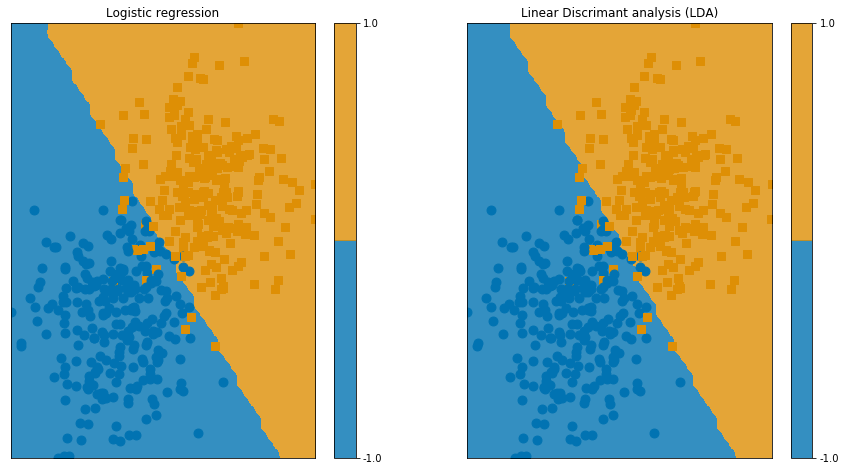

In [37]:

lr=LogisticRegression()
lr.fit(X1[::2],y1[::2])
def f1(x):
    return lr.predict(x)


lda=LinearDiscriminantAnalysis()
lda.fit(X1[::2],y1[::2])

def f2(x):
    return lda.predict(x)

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.title("Logistic regression")

frontiere_new(f2,X1[1::2],y1[1::2])
plt.subplot(122)
plt.title("Linear Discrimant analysis (LDA)")
frontiere_new(f1,X1[1::2],y1[1::2])


#### Observation

La frontière de décisions dans le cas des classifieurs linéaire est la même.

## Question 24 : Régression logistique à la base DIGITS

--------------------------------------------------------------------------
                    Le taux d'erreur est 0.232
--------------------------------------------------------------------------


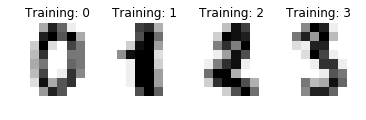

In [36]:
# The digits dataset
digits = datasets.load_digits()
# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: Logistic Regression

classifier=LogisticRegression()
# We learn the digits on the first half of the digits

classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])
# Now predict the value of the digit on the second half:

expected= digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])



#plt.show()----------
print('--------------------------------------------------------------------------')
print(f"                    Le taux d'erreur est {round(1-metrics.r2_score(expected, predicted),3)}")
print('--------------------------------------------------------------------------')

# Conclusion

-----------------------------------------------------------------------------------------------------------------
Dans ce TP :

1. Nous avons vu différents classifieurs  ainsi que leurs avantages et inconvénients:

    1. Un <font color=blue> : classifieur non linéaire <font color=black>"Knn voisins" qui permet de classifier des données non linéairement séparables.
    2. Des<font color=blue> classifieurs linéaires <font color=black>" :  "Logistic regression"  et "LDA" avec le classifieur LDA qui possède des hypothèses plus forte que la régression logistique (hypothèse de gaussianité que la régression logistique n'a pas)

2. Nous avons vu dans le cas du classifieur Knn voisin comment trouver son hyperparamètre optimal à l'aide de cross validation. 

3. Nous avons pu observer aussi dans ce TP, que plus notre modèle est complexe, et moins il est optimal, il tend à faire du overfitting. (cf Vapnik-Chervonenski thèorème pour la théorie)

4. Nous avons aussi vu que plus nous possédons de données, et mieux c'est.



_________________________________________________________________________________________________________________